<h1>
<center>Attention Based Spatial-Temporal Graph Convolutional Networks
for Traffic Flow Forecasting</center>
</h1>

In this notebook we will dive into attentional temporal graph convolution networks where everything new meets Attention + deep learning time series analysis( temporal data) + Graph convolution all in one thing. This is a rewriting of the code of the paper (Attention Based Spatial-Temporal Graph Convolutional Networks for Traffic Flow Forecasting https://ojs.aaai.org/index.php/AAAI/article/view/3881 ), from which we will include quotes and parts of their code. This notebook uses the data prepared in the previous notebook (Processing traffic data for deep learning projects)

In [1]:
import os
from time import time
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:0')
print("CUDA:", USE_CUDA, DEVICE)

from tensorboardX import SummaryWriter
sw = SummaryWriter(logdir='.', flush_secs=5)

import math
from typing import Optional, List, Union

import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.typing import OptTensor
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.transforms import LaplacianLambdaMax
from torch_geometric.utils import remove_self_loops, add_self_loops, get_laplacian
from torch_geometric.utils import to_dense_adj

CUDA: True cuda:0


# Loading data  ( The temporal part)
As discussed in the previous notebook, the data is splitted as follows:

10181 data/target examples will be used as the training set ( 35 days )

3394 data/target examples will be used as the validation set (12 days)

3394 data/target examples will be used as the testing set (12 days)

The shape for each prediction / target hour example is  (12, 307, 3)  , As the data will be loaded in batches of size 32

its shape will be (32, 12, 307, 3)

In [2]:
'''
加载图信号数据，并将其转换为 PyTorch 的 DataLoader
流程：
1.转换数据类型：将 NumPy 数组转换为 PyTorch 张量，并确保它们的数据类型为浮点数。
2.移动到设备：将张量移动到指定的设备（如 GPU）。
3.创建数据集：使用 TensorDataset 将输入张量和目标张量配对，创建一个数据集对象。
4.创建数据加载器：使用 DataLoader 将数据集分成小批量，并设置是否打乱数据。
'''
def load_graphdata_channel1(graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size,
                            shuffle=True, DEVICE = torch.device('cuda:0')):
    '''
    :param graph_signal_matrix_filename: str
    :param num_of_hours: int
    :param num_of_days: int
    :param num_of_weeks: int
    :param DEVICE:
    :param batch_size: int
    shuffle：是否在训练数据加载器中打乱数据。

    :return:
    three DataLoaders, each dataloader contains:
    test_x_tensor: (B, N_nodes, in_feature, T_input)
    test_decoder_input_tensor: (B, N_nodes, T_output)
    test_target_tensor: (B, N_nodes, T_output)
    '''

    file = os.path.basename(graph_signal_matrix_filename).split('.')[0]
    current_directory = os.getcwd()
    print("当前工作目录:", current_directory)
    filename = os.path.join('./data/pems-dataset/PEMS04/', file + '_r' + str(num_of_hours) + '_d' + str(num_of_days) + '_w' + str(num_of_weeks)) +'_astcgn'
    print('load file:', filename)
    file_data = np.load(filename + '.npz')

    train_x = file_data['train_x']  # (10181, 307, 3, 12)
    train_x = train_x[:, :, 0:1, :]
    train_target = file_data['train_target']  # (10181, 307, 12)

    val_x = file_data['val_x']
    val_x = val_x[:, :, 0:1, :]
    val_target = file_data['val_target']

    test_x = file_data['test_x']
    test_x = test_x[:, :, 0:1, :]
    test_target = file_data['test_target']

    mean = file_data['mean'][:, :, 0:1, :]  # (1, 1, 3, 1)
    std = file_data['std'][:, :, 0:1, :]  # (1, 1, 3, 1)

    # ------- train_loader -------
    train_x_tensor = torch.from_numpy(train_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    train_dataset = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)

    '''
    torch.from_numpy 将 NumPy 数组转换为 PyTorch 张量。
    .type(torch.FloatTensor) 将张量的数据类型转换为 FloatTensor，即 32 位浮点数
    .to(DEVICE) 将张量移动到指定的设备（如 GPU 或 CPU）
    torch.utils.data.TensorDataset 创建一个数据集对象，该对象将输入张量和目标张量配对,返回一个TensorDataset对象
    TensorDataset 是PyTorch中的数据集类，用于将多个张量组合成一个数据集。每个样本由输入张量和目标张量组成。
    torch.utils.data.DataLoader 创建一个数据加载器，用于批量加载数据
if loss_function=='masked_mse':    DataLoader 是PyTorch中的一个类，用于将数据集分成小批量，并在训练过程中方便地迭代数据。
    '''


    # ------- val_loader -------
    val_x_tensor = torch.from_numpy(val_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    val_target_tensor = torch.from_numpy(val_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    val_dataset = torch.utils.data.TensorDataset(val_x_tensor, val_target_tensor)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # ------- test_loader -------
    test_x_tensor = torch.from_numpy(test_x).type(torch.FloatTensor).to(DEVICE)  # (B, N, F, T)
    test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(DEVICE)  # (B, N, T)
    test_dataset = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # print 打印数据尺寸
    print('train:', train_x_tensor.size(), train_target_tensor.size())
    print('val:', val_x_tensor.size(), val_target_tensor.size())
    print('test:', test_x_tensor.size(), test_target_tensor.size())

    return train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, mean, std


In [3]:
graph_signal_matrix_filename = './data/pems-dataset/PEMS04/PEMS04.npz'
batch_size = 32
num_of_weeks = 0
num_of_days = 0
num_of_hours = 1

train_loader, train_target_tensor, val_loader, val_target_tensor, test_loader, test_target_tensor, _mean, _std = load_graphdata_channel1(
    graph_signal_matrix_filename, num_of_hours, num_of_days, num_of_weeks, batch_size)

当前工作目录: /home/nevo/github_repo/pyg-ubuntu/example
load file: ./data/pems-dataset/PEMS04/PEMS04_r1_d0_w0_astcgn


FileNotFoundError: [Errno 2] No such file or directory: './data/pems-dataset/PEMS04/PEMS04_r1_d0_w0_astcgn.npz'

# Loading the graph ( The spatial part)

In our case the graph is the Traffic Networks (literally, the network between the detectors (sensors) applied on the traffic networks

In our example we have 307 detectors that when connected spatially, give our traffic network under investigation.

# 加载图表（空间部分）

在我们的例子中，该图是交通网络（字面意思是交通网络上应用的检测器（传感器）之间的网络

在我们的示例中，我们有 307 个探测器，当它们在空间上连接时，可以对我们的交通网络进行调查。

加载图表（空间部分）

在我们的例子中，该图是交通网络（字面意思是交通网络上应用的检测器（传感器）之间的网络

在我们的示例中，我们有 307 个探测器，当它们在空间上连接时，可以对我们的交通网络进行调查。

In [4]:
def get_adjacency_matrix(distance_df_filename, num_of_vertices, id_filename=None):
    '''
    Parameters
    ----------
    distance_df_filename: str, path of the csv file contains edges information
    num_of_vertices: int, the number of vertices
    Returns
    ----------
    A: np.ndarray, adjacency matrix
    '''
    if 'npy' in distance_df_filename:  # false
        adj_mx = np.load(distance_df_filename)
        return adj_mx, None
    else:

        #--------------------------------------------- read from here
        import csv
        A = np.zeros((int(num_of_vertices), int(num_of_vertices)),dtype=np.float32)
        distaneA = np.zeros((int(num_of_vertices), int(num_of_vertices)), dtype=np.float32)

        #------------ Ignore
        if id_filename: # false
            with open(id_filename, 'r') as f:
                id_dict = {int(i): idx for idx, i in enumerate(f.read().strip().split('\n'))}  # 把节点id（idx）映射成从0开始的索引

            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[id_dict[i], id_dict[j]] = 1
                    distaneA[id_dict[i], id_dict[j]] = distance
            return A, distaneA

        else:
         #-------------Continue reading
            with open(distance_df_filename, 'r') as f:
                f.readline()
                reader = csv.reader(f)
                for row in reader:
                    if len(row) != 3:
                        continue
                    i, j, distance = int(row[0]), int(row[1]), float(row[2])
                    A[i, j] = 1
                    distaneA[i, j] = distance
            return A, distaneA

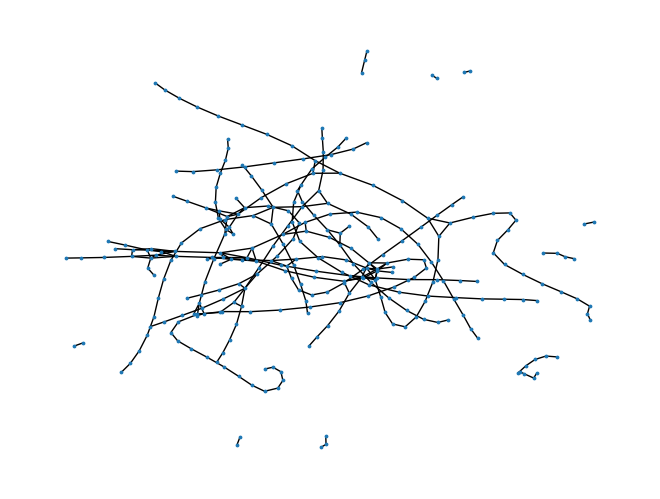

In [5]:
id_filename = None
# 邻接矩阵文件的路径，即存储交通网络连接信息的文件。
adj_filename = './data/pems-dataset/PEMS04/PEMS04.csv'
# num_of_vertices：节点的数量，即传感器的数量
num_of_vertices = 307
# get_adjacency_matrix：用于读取邻接矩阵文件并生成邻接矩阵adj_mx和距离矩阵distance_mx。邻接矩阵adj_mx是一个307x307的矩阵，表示节点之间的连接关系。
adj_mx, distance_mx = get_adjacency_matrix(adj_filename, num_of_vertices, id_filename) #  adj_mx and distance_mx (307, 307)

# 使用 networkx 库创建图并绘制出来。
# 找到邻接矩阵中值为1的位置，这些位置表示节点之间的连接。
rows, cols = np.where(adj_mx == 1)
# 将行和列索引组合成边的列表。
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=3)
plt.show()

# 创建PyTorch张量表示边的索引
rows, cols = np.where(adj_mx == 1)
edges = zip(rows.tolist(), cols.tolist()) # 将行和列索引组合成边的列表。
# torch.LongTensor(np.array([rows, cols]))：将边的行和列索引转换为PyTorch的长整型张量。
edge_index_data = torch.LongTensor(np.array([rows, cols])).to(DEVICE)

# Making the model

# Model Layers

## Temporal attention layer

In the temporal dimension, there exist correlations between the traffic conditions in different time slices, and the correlations are also varying under different situations. Likewise, we use an attention mechanism to adaptively attach different importance to data.

在时间维度上，不同时间片内的交通状况之间存在相关性，且不同情况下相关性也不同。同样，我们使用注意力机制来自适应地对数据赋予不同的重要性

<img src="https://i.ibb.co/KwXCqJx/temp-attention.png" width="400">



To understand the equation :

It learns to attend (focus) on which part of the time segement used as input. In our case we have 12 time points So it will generate 12 by 12 weights.

要理解这个方程：

它学习关注（关注）时间段的哪一部分用作输入。在我们的例子中，我们有 12 个时间点，因此它将生成 12 x 12 的权重。

<img src="https://i.ibb.co/NZ4fh4k/atten2.jpg" width="400">

## Spatial attention layer

In the spatial dimension, the traffic conditions of different locations have influence among each other and the mutual influence is highly dynamic. Here, we use an attention mechanism (Feng et al. 2017) to adaptively capture the dynamic correlations between nodes in the spatial dimension.

空间注意力层

在空间维度上，不同地点的交通状况相互影响，且相互影响是高度动态的。在这里，我们使用注意力机制（Feng et al. 2017）来自适应捕获空间维度中节点之间的动态相关性。

<img src="https://i.ibb.co/PGnj4MR/spatial1.png" width="400">

<img src="https://i.ibb.co/G5jkKvr/spatial2.png" width="400">


The same as with the temporal attention; however, here the attention weights will be used inside a Graph convolution layer



<img src="https://i.ibb.co/stTfTFM/spat2.jpg" width="400">


## Spectral graph analysis on the spatial part
Since the spatial part is represented as a graph, we will apply graph convolution to aggregate messages from neighbor nodes. The type of graph convolution that we are going to use is spectral convolution.

* In spectral graph analysis, a graph is represented by its corresponding Laplacian matrix.
* The properties of the graph structure can be obtained by analyzing Laplacian matrix and its eigenvalues

* Laplacian matrix of a graph is defined as L = D − A,

* Its normalized form is L = I − ((1/ sqrt(D) A ( 1/ sqrt(D))  

where A is the adjacent matrix, I is a unit matrix, and the degree matrix D (diagnoal diagonal matrix, consisting of node degrees,at the diagonal)

The eigenvalue decomposition of the Laplacian matrix is L = U*Λ*(U.transpose()) , where Λ = diag([λ0, ..., λN −1]) is a diagonal matrix, and U is Fourier basis.

U is an orthogonal matrix.

The graph convolution is a convolution operation implemented by using linear operators that diagonalize in the Fourier domain to replace the classical convolution operator.

However, it is expensive to directly perform the eigenvalue decomposition on the Laplacian matrix when the scale of the graph is large. Therefore, Chebyshev polynomials are adopted to solve this problem approximately but efficiently.






# The ASTGCN model structure


The model is composed of two ASTGCN blocks followed by a final layer

Original x (input) is (32, 307, 1, 12) -Block1> (32, 307, 64, 12) -Block2> (32, 307, 64, 12) -permute-> (32, 12, 307,64)
            # -final_conv-> (32, 12, 307, 1) -reshape-> (32,307,12) "The target"
            
该模型是具有相同结构的三个独立组件的融合，旨在分别对历史数据的近期、日周期和周周期依赖性进行建模。这在之前的笔记本中已经讨论过

The model is  the fusion of three independent components with the same structure, which are designed to respectively model the recent, daily-periodic and weekly-periodic dependencies of the historical data. This is discussed in the previous notebook (https://www.kaggle.com/elmahy/processing-traffic-data-for-deep-learning-projects).

But in our case we will only focus on the recent segment (last hour segment) i.e. X_h  

![astgcn.png](attachment:ec80c00c-6836-4449-85ba-e0b9d174a2f5.png)

【debug】/usr/local/lib/python3.10/dist-packages/torch_geometric_temporal/nn/attention/tsagcn.py

删除：from torch_geometric.utils.to_dense_adj import to_dense_adj

增加：from torch_geometric.utils import to_dense_adj

In [6]:
from torch_geometric_temporal.nn.attention import ASTGCN   # For information about the architecture check the source code

# Initialized the ASTGCN model


In [7]:
nb_block = 2
in_channels = 1
K = 3
nb_chev_filter = 64
nb_time_filter = 64
time_strides = num_of_hours
num_for_predict = 12
len_input = 12
#L_tilde = scaled_Laplacian(adj_mx)
#cheb_polynomials = [torch.from_numpy(i).type(torch.FloatTensor).to(DEVICE) for i in cheb_polynomial(L_tilde, K)]
net = ASTGCN( nb_block, in_channels, K, nb_chev_filter, nb_time_filter, time_strides, num_for_predict, len_input, num_of_vertices).to(DEVICE)

print(net)


ASTGCN(
  (_blocklist): ModuleList(
    (0): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(1, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (1): ASTGCNBlock(
      (_temporal_attention): TemporalAttention()
      (_spatial_attention): SpatialAttention()
      (_chebconv_attention): ChebConvAttention(64, 64, K=3, normalization=None)
      (_time_convolution): Conv2d(64, 64, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1))
      (_residual_convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
  )
  (_final_conv): Conv2d(12, 12, kernel_size=(1, 64), strid

In [8]:
# 打印模型的所有参数及其名称
for name, param in net.named_parameters():
    print(f"Layer: {name} | Shape: {param.shape} | Requires Grad: {param.requires_grad}")

Layer: _blocklist.0._temporal_attention._U1 | Shape: torch.Size([307]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._U2 | Shape: torch.Size([1, 307]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._U3 | Shape: torch.Size([1]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._be | Shape: torch.Size([1, 12, 12]) | Requires Grad: True
Layer: _blocklist.0._temporal_attention._Ve | Shape: torch.Size([12, 12]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._W1 | Shape: torch.Size([12]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._W2 | Shape: torch.Size([1, 12]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._W3 | Shape: torch.Size([1]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._bs | Shape: torch.Size([1, 307, 307]) | Requires Grad: True
Layer: _blocklist.0._spatial_attention._Vs | Shape: torch.Size([307, 307]) | Requires Grad: True
Layer: _blocklist.0._chebconv_attention._weight | Sha

In [9]:
#------------------------------------------------------
learning_rate = 0.001
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

print('Net\'s state_dict:')
total_param = 0
'''
state_dict() 方法返回一个字典，其中包含模型的所有参数和缓冲区
param_tensor 是参数的名称。
param_size 是参数张量的大小。
param_device 是参数张量所在的设备。
np.prod(param_size) 计算参数张量中所有元素的乘积，即参数的总数。
'''
for param_tensor in net.state_dict():
    print(param_tensor, '\t', net.state_dict()[param_tensor].size(), '\t', net.state_dict()[param_tensor].device)
    total_param += np.prod(net.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])


Net's state_dict:
_blocklist.0._temporal_attention._U1 	 torch.Size([307]) 	 cuda:0
_blocklist.0._temporal_attention._U2 	 torch.Size([1, 307]) 	 cuda:0
_blocklist.0._temporal_attention._U3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._temporal_attention._be 	 torch.Size([1, 12, 12]) 	 cuda:0
_blocklist.0._temporal_attention._Ve 	 torch.Size([12, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W1 	 torch.Size([12]) 	 cuda:0
_blocklist.0._spatial_attention._W2 	 torch.Size([1, 12]) 	 cuda:0
_blocklist.0._spatial_attention._W3 	 torch.Size([1]) 	 cuda:0
_blocklist.0._spatial_attention._bs 	 torch.Size([1, 307, 307]) 	 cuda:0
_blocklist.0._spatial_attention._Vs 	 torch.Size([307, 307]) 	 cuda:0
_blocklist.0._chebconv_attention._weight 	 torch.Size([3, 1, 64]) 	 cuda:0
_blocklist.0._chebconv_attention._bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._time_convolution.weight 	 torch.Size([64, 64, 1, 3]) 	 cuda:0
_blocklist.0._time_convolution.bias 	 torch.Size([64]) 	 cuda:0
_blocklist.0._residual_

# Defining the loss function

 1. masked_mae 处理缺失值或某些特定值（如填充值）时非常有用。函数通过掩码来忽略这些值，从而计算有效的 MAE。

 平均绝对误差（MAE）


torch.where(condition, x, y)

    condition: 一个布尔张量，表示条件。

    x: 当条件为 True 时选取的值。

    y: 当条件为 False 时选取的值。

In [10]:
def masked_mae(preds, labels, null_val=np.nan):
  '''
  :param: preds（预测值）
          labels（真实标签）
          null_val（表示无效值的标记，默认是 NaN）
  '''
  if np.isnan(null_val):
    # 生成一个掩码 mask，掩码中的每个元素表示 labels 中对应位置是否不是 NaN（即 True 表示不是 NaN，False 表示是 NaN）
    # ~ 按位取反运算符
      mask = ~torch.isnan(labels)
  else:
    # 生成一个掩码 mask，掩码中的每个元素表示 labels 中对应位置是否不等于 null_val
      mask = (labels != null_val)
  mask = mask.float()
  mask /= torch.mean((mask))

  mask = torch.where(torch.isnan(mask), torch.zeros_like(mask), mask)
  # 计算绝对误差: 计算预测值 preds 和真实标签 labels 之间的绝对误差
  loss = torch.abs(preds - labels)
  # 应用掩码: 将绝对误差与掩码相乘，这样掩码为 0 的位置（即无效值位置）的误差将被忽略（置为 0）
  loss = loss * mask
  # 处理误差中的 NaN 值: 将误差中的 NaN 值替换为 0。这是为了防止后续计算中出现 NaN 值
  loss = torch.where(torch.isnan(loss), torch.zeros_like(loss), loss)
  # 返回带掩码的 MAE: 计算并返回误差的均值，即带掩码的平均绝对误差
  return torch.mean(loss)


In [11]:
masked_flag=0
criterion = nn.L1Loss().to(DEVICE)
criterion_masked = masked_mae
loss_function = 'mse'

metric_method = 'unmask'
missing_value=0.0


if loss_function=='masked_mse':
    criterion_masked = masked_mse         #nn.MSELoss().to(DEVICE)
    masked_flag=1
elif loss_function=='masked_mae':
    criterion_masked = masked_mae
    masked_flag = 1
elif loss_function == 'mae':
    criterion = nn.L1Loss().to(DEVICE)
    masked_flag = 0
elif loss_function == 'rmse':
    criterion = nn.MSELoss().to(DEVICE)
    masked_flag= 0

In [12]:
def compute_val_loss_mstgcn(net, val_loader, criterion,  masked_flag,missing_value,sw, epoch, edge_index_data, limit=None):
    '''
    for rnn, compute mean loss on validation set
    :param net: model
    :param val_loader: torch.utils.data.utils.DataLoader
    :param criterion: torch.nn.MSELoss
    :param sw: tensorboardX.SummaryWriter
    :param global_step: int, current global_step
    :param limit: int,
    :return: val_loss
    '''
    # 将模型设置为评估模式 net.eval()
    net.train(False)  # ensure dropout layers are in evaluation mode
    with torch.no_grad():
        val_loader_length = len(val_loader)  # nb of batch
        tmp = []  # batch loss
        for batch_index, batch_data in enumerate(val_loader):
            encoder_inputs, labels = batch_data
            outputs = net(encoder_inputs, edge_index_data)
            # 根据 masked_flag 来选择合适的损失函数。如果 masked_flag 为真，则使用带掩码的损失函数，否则使用标准损失函数。
            if masked_flag:
                loss = criterion(outputs, labels, missing_value)
            else:
                loss = criterion(outputs, labels)
            tmp.append(loss.item())
            if batch_index % 100 == 0:
                print('validation batch %s / %s, loss: %.2f' % (batch_index + 1, val_loader_length, loss.item()))
            if (limit is not None) and batch_index >= limit:
                break

        validation_loss = sum(tmp) / len(tmp)
        sw.add_scalar('validation_loss', validation_loss, epoch)
    return validation_loss

In [13]:
global_step = 0
best_epoch = 0
# np.inf 表示正无穷大
best_val_loss = np.inf
start_time= time()

In [14]:
# train model
def train_model():
  for epoch in range(20):
      params_filename = os.path.join('./data/pems-dataset/', 'epoch_%s.params' % epoch)
      masked_flag = 1
      if masked_flag:
          val_loss = compute_val_loss_mstgcn(net, val_loader, criterion_masked, masked_flag,missing_value,sw, epoch,edge_index_data)
      else:
          val_loss = compute_val_loss_mstgcn(net, val_loader, criterion, masked_flag, missing_value, sw, epoch,edge_index_data)

      if val_loss < best_val_loss:
          best_val_loss = val_loss
          best_epoch = epoch
          torch.save(net.state_dict(), params_filename)
          print('save parameters to file: %s' % params_filename)

      # 训练模式
      net.train()  # ensure dropout layers are in train mode

      for batch_index, batch_data in enumerate(train_loader):
          encoder_inputs, labels = batch_data   # encoder_inputs torch.Size([32, 307, 1, 12])  label torch.Size([32, 307, 12])
          # 清除上一步的梯度。
          optimizer.zero_grad()
          # 前向传播计算模型输出
          outputs = net(encoder_inputs, edge_index_data) # torch.Size([32, 307, 12])

          if masked_flag:
              loss = criterion_masked(outputs, labels,missing_value)
          else :
              loss = criterion(outputs, labels)

          # 反向传播计算梯度
          loss.backward()
          #  更新模型参数
          optimizer.step()
          training_loss = loss.item()
          global_step += 1
          sw.add_scalar('training_loss', training_loss, global_step)

          if global_step % 200 == 0:
              print('global step: %s, training loss: %.2f, time: %.2fs' % (global_step, training_loss, time() - start_time))

In [15]:
# 检查是否存在已训练好的参数文件
params_filename = os.path.join('./data/pems-dataset/', 'epoch_12.params')
best_params_file = None
if os.path.exists(params_filename):
  best_params_file = params_filename
  best_epoch = 12

if best_params_file:
  print(f'Found trained parameters file: {best_params_file}')
  net.load_state_dict(torch.load(best_params_file))
  print('Loaded best model parameters. Skipping training and entering evaluation mode.')
else:
  print('No trained model parameters file found. Starting training.')
  train_model()

No trained model parameters file found. Starting training.
validation batch 1 / 107, loss: 277.47
validation batch 101 / 107, loss: 333.76


UnboundLocalError: cannot access local variable 'best_val_loss' where it is not associated with a value

In [ ]:
# model.eval()
net.train(False)  # ensure dropout layers are in evaluation mode
with torch.no_grad():
    test_loader_length = len(test_loader)  # nb of batch
    tmp = []  # batch loss
    for batch_index, batch_data in enumerate(test_loader):
        encoder_inputs, labels = batch_data
        outputs = net(encoder_inputs, edge_index_data)
        loss = criterion(outputs, labels)
        tmp.append(loss.item())
        if batch_index % 100 == 0:
            print('test_loss batch %s / %s, loss: %.2f' % (batch_index + 1, test_loader_length, loss.item()))


    test_loss = sum(tmp) / len(tmp)
    sw.add_scalar('test_loss', test_loss, epoch)
print(test_loss)

# Pickig a random time point and visualizing the predictions of the first 50 detectors

In [ ]:
sample_output = outputs[0]  # prediction
sample_labels = labels[0] # truth
print(sample_output.shape, sample_labels.shape)

In [ ]:
sample_labels[0][1]

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(30,4), dpi=80)
for i in range(50):
    new_i = i * 12
    plt.plot(range(0+new_i,12+new_i),sample_output[i].detach().cpu().numpy(), color = 'red')
    plt.plot(range(0+new_i,12+new_i),sample_labels[i].cpu().numpy(), color='blue')
plt.show()